In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as p_r_f1_scores
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

import seaborn as sns

import heapq
from collections import Counter

%matplotlib inline

Name: Abdullah Osama Sayed
ID: 1802994

## Helpers

In [2]:
all_scores = pd.DataFrame(columns=["Classifier", "Precision", "Recall", "F-Score", "ROC_AUC", "Accuracy"])
y_predictions = dict()

In [3]:
def scores(y_true, y_pred, y_pred_prob):
    prec, recall, f1, n = p_r_f1_scores(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    acc = accuracy_score(y_true, y_pred)
    return [prec, recall, f1, roc_auc, acc]

In [4]:
def metrics(y_true, y_pred, y_pred_prob_posi): 
    print("\nEvaluation Metrics\n")
    
    # Confusion Matrix where C[i][j] represents true value is in class i and predicted to be in class j
    # C[1][1] true value is class 1 and predicted to be in class 1 
    # That is C[1][1] is True Positive
    # C[0][0] is True Negative
    cm = confusion_matrix(y_true, y_pred)
    cm_matrix = pd.DataFrame(data=cm, index=["Actual Negative: 0", "Actual Positive: 1"], 
                             columns=["Predicted Negative: 0", "Predicted Postive: 1"])

    sns.heatmap(cm_matrix, annot=True, fmt='d')

    print(classification_report(y_true, y_pred))
    # TPR = TP / (TP + FN)
    # FPR = FP / (FP + TN)
    fpr, tpr, thres = roc_curve(y_true, y_pred_prob_posi)
    plt.figure()
    plt.plot(fpr, tpr, linewidth="2")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
    
    auc = roc_auc_score(y_true, y_pred_prob_posi)
    print("roc_auc: ", auc)

## Importing Data

In [5]:
df = pd.read_csv("./data.csv", index_col=0)
df.head(20)

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
5,23,8,0,44.0,0,1,14,31,19,12,3,1,0,0
6,105,8,1,34.0,0,1,14,31,19,12,3,1,0,0
7,13,8,1,37.0,1,0,14,31,19,12,3,1,6,0
8,13,8,1,39.0,1,0,14,31,19,12,3,1,5,0
9,13,8,1,56.0,1,0,14,31,19,12,3,1,4,0


In [6]:
df.shape

(863, 14)

In [7]:
col_names = df.columns
col_names

Index(['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan',
       'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6',
       'diff_sym_hos', 'result'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 101.1 KB


In [9]:
for col in df.columns:
    print("Number of values in {}: {}".format(col, len(df[col].unique())))

Number of values in location: 139
Number of values in country: 34
Number of values in gender: 3
Number of values in age: 81
Number of values in vis_wuhan: 2
Number of values in from_wuhan: 2
Number of values in symptom1: 25
Number of values in symptom2: 32
Number of values in symptom3: 20
Number of values in symptom4: 13
Number of values in symptom5: 4
Number of values in symptom6: 2
Number of values in diff_sym_hos: 18
Number of values in result: 2


In [10]:
for col in df.columns:
    print(df[col].value_counts())

108    85
45     78
44     43
114    37
110    33
       ..
8       1
77      1
60      1
37      1
15      1
Name: location, Length: 139, dtype: int64
18    172
8     155
13     90
24     86
12     54
29     37
11     35
28     33
25     32
23     31
30     17
4      17
32     15
15     14
31     14
2      11
7      10
19      9
33      8
21      4
14      3
17      3
3       2
9       1
1       1
0       1
6       1
20      1
16      1
5       1
26      1
10      1
22      1
27      1
Name: country, dtype: int64
1    389
0    302
2    172
Name: gender, dtype: int64
49.4    223
55.0     65
65.0     44
45.0     36
75.0     32
       ... 
74.0      1
4.0       1
78.0      1
11.0      1
81.0      1
Name: age, Length: 81, dtype: int64
0    706
1    157
Name: vis_wuhan, dtype: int64
0    770
1     93
Name: from_wuhan, dtype: int64
14    644
6     143
2      37
4       7
20      7
21      3
18      2
22      2
24      2
15      1
0       1
5       1
23      1
16      1
17      1
7       1
9

In [11]:
df[df["diff_sym_hos"] < 0]

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
223,56,18,1,35.0,0,0,6,31,19,12,3,1,-1,0
240,128,18,1,65.0,0,0,6,31,19,12,3,1,-5,0


#### Two rows have negative 'diff_sym_hos' which is wrong since it should represent days 
I will assume it was zero

In [12]:
df.loc[df["diff_sym_hos"] < 0, "diff_sym_hos"] = 0

### Country has 34 classes

In [13]:
print(df["country"].value_counts())
print(len(df["country"].unique()))

18    172
8     155
13     90
24     86
12     54
29     37
11     35
28     33
25     32
23     31
30     17
4      17
32     15
15     14
31     14
2      11
7      10
19      9
33      8
21      4
14      3
17      3
3       2
9       1
1       1
0       1
6       1
20      1
16      1
5       1
26      1
10      1
22      1
27      1
Name: country, dtype: int64
34


##### Some of them occur only once 

percentage of frequency distibution of countries

In [14]:
print(df["country"].value_counts() / df.shape[0])

18    0.199305
8     0.179606
13    0.104287
24    0.099652
12    0.062572
29    0.042874
11    0.040556
28    0.038239
25    0.037080
23    0.035921
30    0.019699
4     0.019699
32    0.017381
15    0.016222
31    0.016222
2     0.012746
7     0.011587
19    0.010429
33    0.009270
21    0.004635
14    0.003476
17    0.003476
3     0.002317
9     0.001159
1     0.001159
0     0.001159
6     0.001159
20    0.001159
16    0.001159
5     0.001159
26    0.001159
10    0.001159
22    0.001159
27    0.001159
Name: country, dtype: float64


We will try to decrease number of classes of 'country' by assigning a class for each country that has frequency above 0.1 and the others will be grouped in one group that be considered as 'other' or 'else' group
(Binning)

In [15]:
newCountry = pd.DataFrame(data=df['country'], columns=["country"]) 
# print(newCountry.head())
newCounter = 1
for country, freq in \
        zip(df['country'].value_counts().keys().to_list(), df['country'].value_counts().to_list()):
    if freq / df.shape[0] >= 0.1:
        newCountry.loc[df['country'] == country, 'country'] = newCounter
        newCounter += 1
    else:
        newCountry.loc[df['country'] == country, 'country'] = 0

In [16]:
print(newCountry.value_counts())

country
0          446
1          172
2          155
3           90
dtype: int64


Now it has 4 unique variables 1,2,3 for countries and '0' represents other countries

Now we will one hot encode country

In [17]:
newCountry = pd.get_dummies(newCountry, columns=['country'])

In [18]:
newCountry.shape

(863, 4)

In [19]:
df = df.drop(['country'], axis=1)
df = pd.concat([df, newCountry], axis=1)

### We will look at symptoms

In [20]:
symptoms = ["symptom1", "symptom2", "symptom3", "symptom4", "symptom5", "symptom6"]
for sym in symptoms:
    print(df[sym].value_counts())

14    644
6     143
2      37
4       7
20      7
21      3
18      2
22      2
24      2
15      1
0       1
5       1
23      1
16      1
17      1
7       1
9       1
19      1
13      1
11      1
8       1
12      1
1       1
10      1
3       1
Name: symptom1, dtype: int64
31    724
7      54
12     15
17     14
5       8
27      8
13      4
28      4
24      4
10      2
15      2
25      2
19      2
9       2
16      1
29      1
8       1
14      1
3       1
18      1
4       1
1       1
21      1
26      1
23      1
11      1
6       1
22      1
2       1
0       1
30      1
20      1
Name: symptom2, dtype: int64
19    803
8      10
6       7
15      6
5       5
16      5
14      5
7       5
3       4
2       3
11      1
18      1
12      1
9       1
17      1
10      1
13      1
0       1
4       1
1       1
Name: symptom3, dtype: int64
12    844
2       3
0       2
7       2
3       2
1       2
9       2
8       1
11      1
5       1
10      1
6       1
4       1
Name: symptom

In Symptoms 1 to 4 
we can notice that most of samples are concentrated in one or two values and the others are not repeated that much.

In [21]:
df[["symptom1", "symptom2", 'symptom3', 'symptom4']]

,symptom1,symptom2,symptom3,symptom4
0,14,31,19,12
1,14,31,19,12
2,14,31,19,12
3,14,31,19,12
4,14,31,19,12
...,...,...,...,...
858,14,31,19,12
859,14,31,19,12
860,14,31,19,12
861,14,31,19,12


##### Symptom1 has alot of values that doesn;t have high frequency 

##### I will take a similar approach to what have been done to 'country' feature above

In [22]:
changedSymp = ['symptom1', 'symptom2', 'symptom3', 'symptom4']
newSymptoms = pd.DataFrame(data=df[changedSymp])
for symptom in changedSymp:
    counter = 1
    for symi, cnt in \
        zip(df[symptom].value_counts().keys().to_list(), df[symptom].value_counts().to_list()):
        if cnt / df.shape[0] >= 0.05:
            newSymptoms.loc[df[symptom] == symi, symptom] = counter
            counter += 1
        else:
            newSymptoms.loc[df[symptom] == symi, symptom] = 0

In [23]:
for i in changedSymp:
    print(newSymptoms[i].value_counts())

1    644
2    143
0     76
Name: symptom1, dtype: int64
1    724
0     85
2     54
Name: symptom2, dtype: int64
1    803
0     60
Name: symptom3, dtype: int64
1    844
0     19
Name: symptom4, dtype: int64


In [24]:
df = df.drop(changedSymp, axis=1)
df = pd.concat([df, newSymptoms[changedSymp]], axis=1)

In [25]:
df

,location,gender,age,vis_wuhan,from_wuhan,symptom5,symptom6,diff_sym_hos,result,country_0,country_1,country_2,country_3,symptom1,symptom2,symptom3,symptom4
0,104,1,66.0,1,0,3,1,8,1,0,0,1,0,1,1,1,1
1,101,0,56.0,0,1,3,1,0,0,0,0,1,0,1,1,1,1
2,137,1,46.0,0,1,3,1,13,0,0,0,1,0,1,1,1,1
3,116,0,60.0,1,0,3,1,0,0,0,0,1,0,1,1,1,1
4,116,1,58.0,0,0,3,1,0,0,0,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,48,2,24.0,0,0,3,1,0,1,1,0,0,0,1,1,1,1
859,0,2,35.0,0,0,3,1,0,0,1,0,0,0,1,1,1,1
860,3,1,49.4,0,0,3,1,0,0,1,0,0,0,1,1,1,1
861,24,1,49.4,0,0,3,1,0,0,1,0,0,0,1,1,1,1


### We can see that the target variable is imbalanced

In [26]:
df["result"].value_counts() / len(df)

0    0.874855
1    0.125145
Name: result, dtype: float64

Since the target class is imbalanced we will keep an eye on metrics other than accuracy as F1, Recall and Precision

### Spliting features from target

We will drop location since it suffers from high cardinality and part of the information that location feature gives is already related to country feature as location is part of the country

In [27]:
y = df["result"]
X = df.drop(["result", "location"], axis=1)
print("y dimensions:{} X dimesions:{}".format(y.shape,X.shape))

y dimensions:(863,) X dimesions:(863, 15)


### Spliting data to training and test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=22, shuffle=True, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(690, 15) (173, 15) (690,) (173,)


In [29]:
print(y_train.value_counts(), '\n',y_test.value_counts())

0    604
1     86
Name: result, dtype: int64 
 0    151
1     22
Name: result, dtype: int64


In [30]:
X_train.head(5)

,gender,age,vis_wuhan,from_wuhan,symptom5,symptom6,diff_sym_hos,country_0,country_1,country_2,country_3,symptom1,symptom2,symptom3,symptom4
783,0,36.0,0,0,3,1,0,1,0,0,0,1,1,1,1
791,0,49.4,0,0,3,1,0,1,0,0,0,1,1,1,1
295,1,85.0,0,0,3,1,0,0,1,0,0,1,1,1,1
365,0,53.0,0,0,3,1,0,1,0,0,0,1,1,1,1
861,1,49.4,0,0,3,1,0,1,0,0,0,1,1,1,1




# Logistic Regression



In [31]:
logreg = LogisticRegression(solver='liblinear', random_state=15)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=15, solver='liblinear')


Evaluation Metrics

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       151
           1       0.88      0.64      0.74        22

    accuracy                           0.94       173
   macro avg       0.91      0.81      0.85       173
weighted avg       0.94      0.94      0.94       173



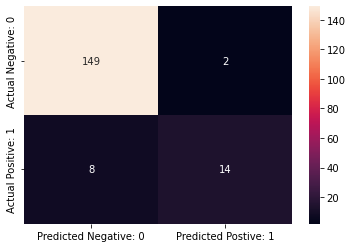

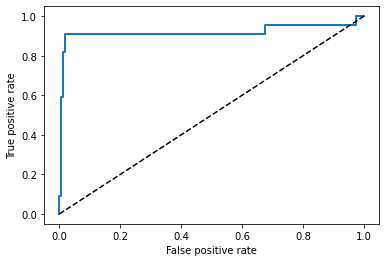

roc_auc:  0.9169175195665261


In [32]:
y_test_predict_lr = logreg.predict(X_test)
y_test_predict_lr = pd.DataFrame(y_test_predict_lr)
y_test_predict_proba_lr = logreg.predict_proba(X_test)[:, 1]
metrics(y_test, y_test_predict_lr, y_test_predict_proba_lr)

In [33]:
cvs = cross_val_score(logreg, X_train, y_train, cv = 10, scoring='recall')
print('Mean of cross validations scores: {} std: {}'.format(cvs.mean(), cvs.std()))

Mean of cross validations scores: 0.6319444444444444 std: 0.15494050032827217


### Grid Search Cross validation
Grid Search uses provided parameters and form combinations of all parameters to create models and cross validates using the training data set and compares different models using the score.
'refit' causes it to train a model on all the training data using the best found parameters

In [34]:
parameters = [{ 'penalty':['l1','l2'] , 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'solver':['liblinear'] }]
logR = LogisticRegression()
gsLR = GridSearchCV(estimator = logR,  
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 10,
                           verbose=0, 
                          refit=True)

gsLR.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             scoring='recall')

In [35]:
print("Score from grid search: {}, beat parameters: {}".format(gsLR.best_score_, gsLR.best_params_))

Score from grid search: 0.6986111111111111, beat parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
y_test_predict_lr = pd.DataFrame(gsLR.predict(X_test))
y_test_predict_proba_lr = pd.DataFrame(gsLR.predict_proba(X_test)[:, 1])


Evaluation Metrics

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       151
           1       0.88      0.64      0.74        22

    accuracy                           0.94       173
   macro avg       0.91      0.81      0.85       173
weighted avg       0.94      0.94      0.94       173



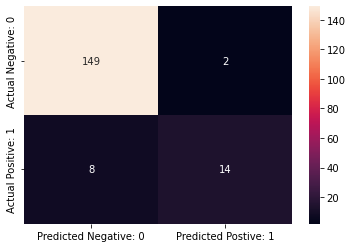

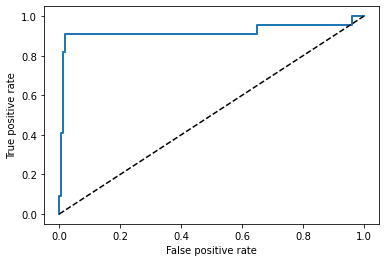

roc_auc:  0.917519566526189


In [37]:
metrics(y_test, y_test_predict_lr, y_test_predict_proba_lr)

Since the target variable is imbalanced we can give the positive class more weight since it is the less frequent class and we are more intersted in positive cases


Evaluation Metrics

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       151
           1       0.83      0.91      0.87        22

    accuracy                           0.97       173
   macro avg       0.91      0.94      0.92       173
weighted avg       0.97      0.97      0.97       173



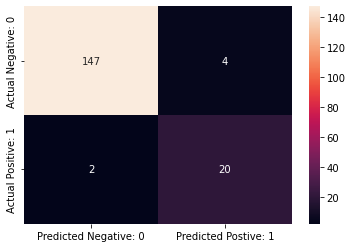

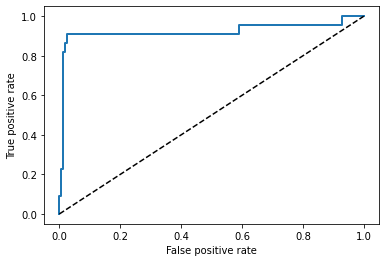

roc_auc:  0.9202287778446717


In [38]:
lrWithWeight = LogisticRegression(C=10, penalty="l1", solver="liblinear", class_weight={0:0.35, 1: 0.65})
lrWithWeight.fit(X_train, y_train)
lr_w = lrWithWeight.predict(X_test)
lr_w_proba = lrWithWeight.predict_proba(X_test)[:, 1]
metrics(y_test, lr_w, lr_w_proba)

As we see recall has significantly improved, f1 score got better and roc_auc is still as good as the previous classifier

In [39]:
sc = scores(y_test, lr_w, lr_w_proba)
all_scores.loc["lr"] = ["Logistic Regression"] + sc
y_predictions["Logistic Regression"] = [lr_w, lr_w_proba]

# K Nearest Neighbors Classifier
#### Starting with default n_neighbor


Evaluation Metrics

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       151
           1       0.89      0.77      0.83        22

    accuracy                           0.96       173
   macro avg       0.93      0.88      0.90       173
weighted avg       0.96      0.96      0.96       173



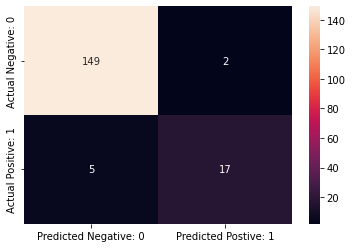

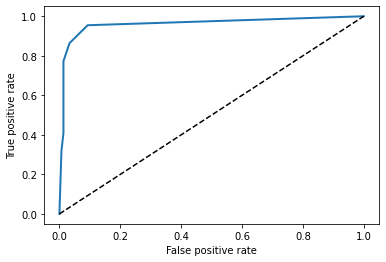

roc_auc:  0.9605659241420831


In [40]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred)

y_test_pred_prob = knn.predict_proba(X_test)[:, 1]

metrics(y_test, y_test_pred, y_test_pred_prob)

### Finding optimal hyperparameters

### Looking for the optimal hyperparameters to maximize the f1-score of the model
#### We will compare with cross validation between different values of K neighbors and the distance metrics (Manhattan and Euclidean)

In [41]:
knn_range = list(range(3, 52, 2))
knn_parameters = {
    'n_neighbors': knn_range,
    'p': [1, 2]
}

In [42]:
knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, knn_parameters, 
                       cv=StratifiedKFold(10, shuffle=True, random_state=10),
                       scoring='recall', refit=True)
clf_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51],
                         'p': [1, 2]},
             scoring='recall')

In [43]:
print("Best score: {:.4f} \nBest Estimator: {} ".format(clf_knn.best_score_, clf_knn.best_params_))

Best score: 0.6792 
Best Estimator: {'n_neighbors': 3, 'p': 1} 


### Predicitng using optimal hyperparamters


Evaluation Metrics

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       151
           1       0.85      0.77      0.81        22

    accuracy                           0.95       173
   macro avg       0.91      0.88      0.89       173
weighted avg       0.95      0.95      0.95       173



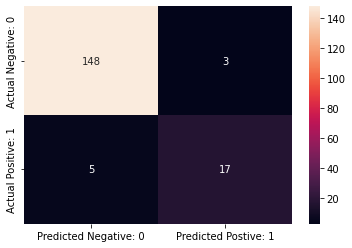

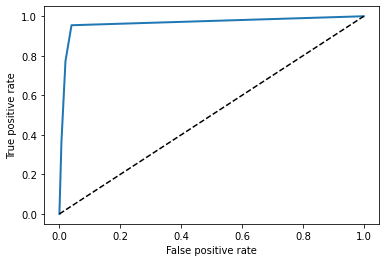

roc_auc:  0.9643287176399759


In [44]:
y_test_predict_knn_gs = pd.DataFrame(clf_knn.predict(X_test))
y_test_predict_proba_knn_gs = pd.DataFrame(clf_knn.predict_proba(X_test)[:, 1])

metrics(y_test, y_test_predict_knn_gs, y_test_predict_proba_knn_gs)

In [45]:
all_scores.loc["KNN"] = ["K Nearest Neighbor"] + scores(y_test, y_test_predict_knn_gs, y_test_predict_proba_knn_gs)
y_predictions["KNN"] = [y_test_predict_knn_gs, y_test_predict_proba_knn_gs]

### Building my own K Nearest Neighbour 

In [46]:
class my_knn:
    
    def __init__(self, k=1, p=1):
        self.k = k
        self.p = p
        pass
    
    def distance(self, x, y, p=1):
        dis = np.sum((abs(x - y)) ** p)
        dis = dis ** (1/p)
        return dis
    
    def fit(self, X, y):
        self.X = X    
        self.y = y
        
        
    def predict(self, X_test):
        X_predict = np.zeros(len(X_test), dtype=int)
        for indx in range(len(X_test)):
            k_nearest_indexes = self.nearest_K(X_test.iloc[indx])
            X_predict[indx] = Counter(self.y.iloc[k_nearest_indexes]).most_common()[0][0]
        return X_predict
    
    
    def nearest_K(self, x):
        heap = []
        for indx in range(len(self.X)):
            dis = self.distance(self.X.iloc[indx], x, self.p)
            if(len(heap) < self.k):
                heapq.heappush(heap, edge(-1 * dis, indx))
            else: 
                heapq.heappushpop(heap, edge(-1 * dis, indx))
        return list(map(lambda x: x.index, heap))
            
        
class edge:
    def __init__(self, dis, index):
        self.index = index
        self.distance = dis
    def __lt__(self, other):
        return self.distance < other.distance
    def __eq__(self, other):
        return self.distance == other.distance
    def __str__(self):
        return str([self.distance, self.index])
    def __repr__(self):
        return str([self.distance, self.index])

In [47]:
myKNN = my_knn(k=3, p=1)
myKNN.fit(X_train, y_train)
myKNN_predict = myKNN.predict(X_test)

### Comparing results with sklearn's KNN classifier results

In [48]:
print(accuracy_score(myKNN_predict, y_test_predict_knn_gs))

0.9884393063583815


# Naive Bayes Classifier

In [49]:
NB = GaussianNB(var_smoothing=0.00001)
NB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [50]:
cvs = cross_val_score(NB, X_train, y_train, cv = 10, scoring='recall')
print('Mean of cross-validations scores: {} std: {}'.format(cvs.mean(), cvs.std()))

Mean of cross-validations scores: 0.7361111111111112 std: 0.09460770203292446



Evaluation Metrics

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       151
           1       0.42      0.77      0.55        22

    accuracy                           0.84       173
   macro avg       0.69      0.81      0.72       173
weighted avg       0.89      0.84      0.86       173



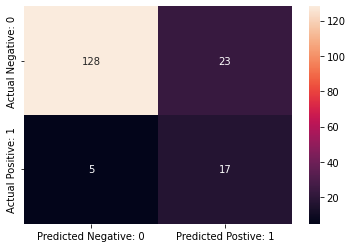

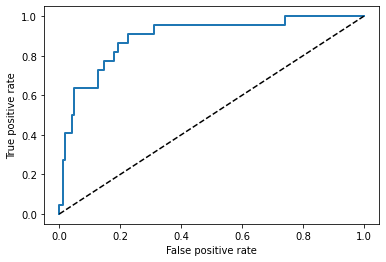

roc_auc:  0.8913305237808548


In [51]:
y_test_predict_NB = pd.DataFrame(NB.predict(X_test))
y_test_predict_proba_NB = pd.DataFrame(NB.predict_proba(X_test)[:, 1])

all_scores.loc["NB"] = ["Naive Bayes"] + scores(y_test, y_test_predict_NB, y_test_predict_proba_NB)
y_predictions["Naive Bayes"] = [y_test_predict_NB, y_test_predict_proba_NB]
metrics(y_test, y_test_predict_NB, y_test_predict_proba_NB)

#  Performance of all classifiers

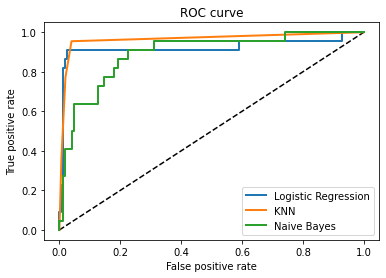

In [52]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
for k, v in y_predictions.items():
    fpr, tpr, thres = roc_curve(y_test, v[1])
    plt.plot(fpr, tpr, label=k, linewidth=2)
plt.legend()
plt.show()

In [53]:
all_scores

,Classifier,Precision,Recall,F-Score,ROC_AUC,Accuracy
lr,Logistic Regression,0.833333,0.909091,0.869565,0.920229,0.965318
KNN,K Nearest Neighbor,0.850000,0.772727,0.809524,0.964329,0.953757
NB,Naive Bayes,0.425000,0.772727,0.548387,0.891331,0.838150


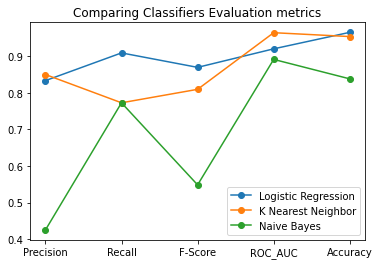

In [54]:
plt.title("Comparing Classifiers Evaluation metrics")
for row in range(all_scores.shape[0]):
    plt.plot(all_scores.columns[1:], all_scores.iloc[row][1:], label=all_scores.iloc[row][0], marker='o')
plt.legend()